# Resaercher Evaluation - H-index

# 説明

## h-index（h指数）とは何か？

h-indexはアメリカの物理学者Jorge E. Hirsch氏が2005年に発表した研究者の評価指標です。

> 要旨：私は、研究者の科学的産出を特徴づける有用な指標として、被引用数がhより大きい論文の数と定義される指数hを提案した。
> 
>> Abstract: I propose the index h, defined as the number of papers with citation number ≥h, as a useful index to characterize the scientific output of a researcher. 
> 
> Hirsch, J. E. (2005). An index to quantify an individual's scientific research output. Proceedings of the National Academy of Sciences, 102(46), 16569-16572. https://www.pnas.org/doi/abs/10.1073/pnas.0507655102

ある科学者が発表したN本論文の中で、**h回以上引用された論文がh本あり**、それ以外のN-h本論文の被引用数が全部hより小さい場合、その科学者の**h-indexはh**です。
 
例えば、h-index=**20**というのは、被引用数が**20**以上の論文が**20**本あり、それ以外の論文はすべて被引用数が20本未満だということです。

## なぜ提案したのか？どうして重要なのか？

リソースが限られた世界で、個人の科学的成果の累積的影響力を定量化することは、評価や比較のために必要とされます。

|指数|長所|短所|
|:-|:-|:-|
|発表論文数(N)|研究者の生産力を測る|論文の影響力が無視される|
|総被引用数(C)|研究者の総影響力を測る|1. 少数の大ヒット論文に歪まれる可能性があり、特に、これらの大ヒットが共著である場合、個人のキャリア全体を代表していない可能性がある。<br>2. 引用度の高いレビューに過度な重みを与えている。|
|平均被引用数(C/N)|異なる年齢の科学者を比較することができる|1. 生産性が高い研究者に不利になる。2. 高被引用数の論文に歪まれる可能性がある。|
|被引用数≥cの論文数|上記の指標の欠点を克服し、広範囲かつ持続的な影響を測る。|cは任意であり、一部の科学者に有利な一方で他の科学者には不利になる。|
|上位q個の論文の被引用数|上記の指標の欠点をほとんど克服する。|1. 単一の数値ではないため、科学者を比較するには困難である。<br>2. qは任意であり、一部の科学者に有利な一方で他の科学者には不利になる。|


# 算出

## 0. 準備：pyalex

In [ ]:
import sys
import os

%cd /content/sample_data/
!git clone https://github.com/ScisciJP/scisciJP2024_tutorial.git

sys.path.append('/content/sample_data/scisciJP2024_tutorial')
print(os.getcwd())
os.chdir('/content/sample_data/scisciJP2024_tutorial')
sys.path


In [1]:
%pip install pyalex

Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyalex
from pyalex import Works, Authors, Institutions
from pprint import pprint
import util

# pyalex.config.email = "your@email.address"
pyalex.config.email = "wangsiyuan1209@gmail.com"

def plot_citations(ax, citations, *,\
                   xlabel='Papers', ylabel='# Citations', title='',\
                   logx=False, logy=False, showline=False, h_index=0):

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # log plotを設定する
    if logx: 
        ax.set_xscale('log')
    if logy: 
        ax.set_yscale('log')
    
    # stem plotで論文の被引用数を表示する
    markerline, stemlines, baseline = ax.stem(np.arange(1, len(citations) + 1), citations, basefmt=" ")
    
    # stemの線を表示するかを設定する
    if showline:
        plt.setp(stemlines, 'color', 'skyblue')
        plt.setp(markerline, 'color', 'lightcoral')
    else:
        stemlines.remove()
        plt.setp(markerline, 'color', 'C0')
    
    # h_indexが入力される場合、45°の補助線を表示する
    if h_index!=0:
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        ax.plot([1, h_index], [1, h_index], ls="--", color='crimson')
        ax.plot(xlim, [h_index, h_index], color='gray', linestyle='--')
        ax.plot([h_index, h_index], ylim, color='gray', linestyle='--')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

## １. h-indexの計算方法：Dashun Wangを例に

SciSci分野において有名な研究者のDashun Wangを例に、h-indexの計算方法を示します。

主な変数：
- citations_test: 論文の発表日順に並べた被引用数のリスト。
- sorted_citations_test: 被引用数が大きい順に並べた被引用数のリスト。

In [3]:
# まずは、pyalexのsearch_filterを使用してDashun Wangのデータを検索します
name = "Dashun Wang"
authors_json = Authors().search_filter(display_name=name).get()
authors_df = pd.DataFrame(authors_json)
display(authors_df)

,id,orcid,display_name,display_name_alternatives,relevance_score,works_count,cited_by_count,summary_stats,ids,affiliations,last_known_institution,last_known_institutions,x_concepts,counts_by_year,works_api_url,updated_date,created_date
0,https://openalex.org/A5002041772,https://orcid.org/0000-0002-7054-2206,Dashun Wang,"[Dashun Wang, Wang Da‐shun]",6332.4556,130,5638,"{'2yr_mean_citedness': 3.048780487804878, 'h_i...",{'openalex': 'https://openalex.org/A5002041772...,[{'institution': {'id': 'https://openalex.org/...,"{'id': 'https://openalex.org/I111979921', 'ror...","[{'id': 'https://openalex.org/I111979921', 'ro...","[{'id': 'https://openalex.org/C41008148', 'wik...","[{'year': 2024, 'works_count': 2, 'cited_by_co...",https://api.openalex.org/works?filter=author.i...,2024-03-08T02:51:48.593312,2023-07-21


In [4]:
# 次に、Dashun Wangのidを使用し、彼が発表したすべての論文の被引用数を獲得します
author_id = authors_df.loc[0,"id"]
pyalexObj = Works().filter(author={"id":author_id},is_paratext=False)\
                .select(["cited_by_count"])\
                .sort(publication_date="asc") # 発表日順に並べ替えます
citations_json = util.getAll(pyalexObj)
citations_test= np.array([entry['cited_by_count'] for entry in citations_json])

Fetching 130 objects. it may takes 0.01 to 0.03 minutes


2it [00:01,  1.05it/s]


In [5]:
# そして、h-indexを算出します
# 被引用数を大きい順に並べ替えます
sorted_citations_test = np.array(np.sort(citations_test)[::-1])

# 比較用のランキング
ranking = np.arange(1,sorted_citations_test.size+1)

# メソッド１：被引用数が論文のランキングより大きい論文を数えます。
h_index = np.sum(sorted_citations_test >= ranking)
print(f"The h-index of the researcher is: {h_index}. (method 1)")

# メソッド２：図に示したように、論文被引用数の曲線と45°直線の交点の横座標がh-index。
h_index = np.max(np.minimum(sorted_citations_test, ranking))
print(f"The h-index of the researcher is: {h_index}. (method 2)")

The h-index of the researcher is: 28. (method 1)
The h-index of the researcher is: 28. (method 2)


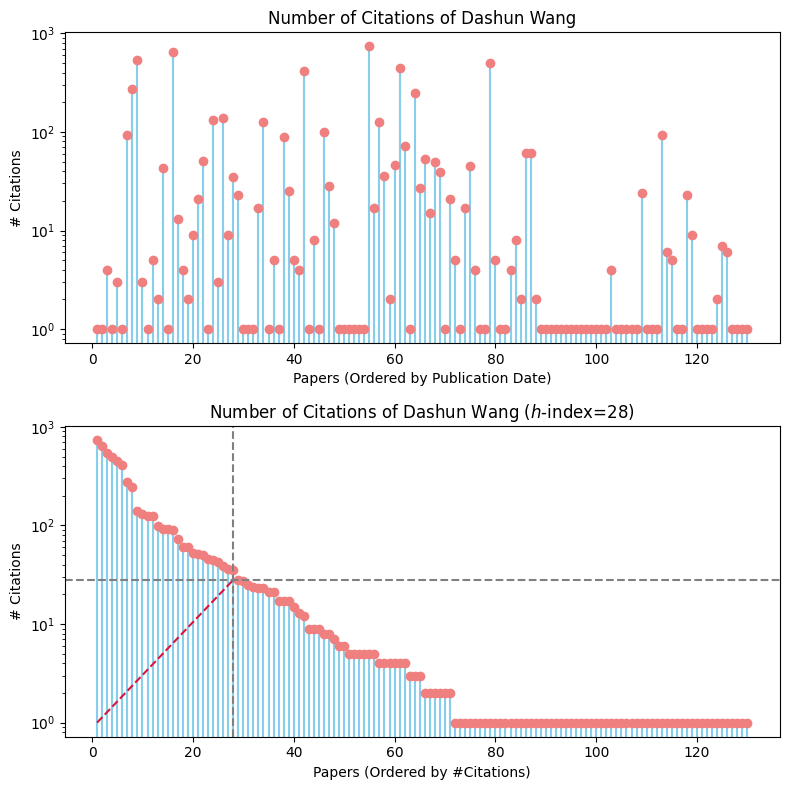

In [6]:
# グラフを作成します。logyを使うため、yをcitations+1にします。
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
# 上のグラフは発表日順に並べた論文の被引用数
plot_citations(axs[0], citations_test+1, showline=True, logy=True,\
               xlabel='Papers (Ordered by Publication Date)',\
               title=f'Number of Citations of {name}')
# 下のグラフは被引用数順に並べた論文の被引用数
plot_citations(axs[1], sorted_citations_test+1, showline=True, logy=True, h_index=h_index,\
               xlabel='Papers (Ordered by #Citations)', \
               title=f'Number of Citations of {name} ($h$-index={h_index})')
plt.tight_layout()
plt.show()

## 2. 実データからh-indexの算出

Section 1のh-index計算方法を関数化して、openalexの実データからある研究者のh-indexを算出します。

主な変数：
- name: 検索のためのauthor_name。
- authors_df: 著者の検索結果。 
- author_id, author_name: 検索結果から指定された著者のidと名前。
- citations: 指定された著者の論文の被引用数（大きい順に並べ替えた）。  

In [7]:
# ここでは、Section 1のメソッド２を使います。
def calculate_h_index(citations):
    if len(citations)==0:
        return 0
    else:
        citations = np.array(citations)
        citations[::-1].sort()
        ranking = np.arange(1,citations.size+1)
        h_index = np.max(np.minimum(citations, ranking))
        return h_index

In [8]:
# ブラックホールの研究者のHawkingを検索します。
name = "Hawking"
# 別の研究者に変えることもできます。
# もともとはEinsteinを例に計算していたが、Einsteinのデータは最近更新されているらしいです。
# 同じプログラムでh-indexを計算しても、この前は78、3月8日には29、3月9日には19という結果になりました。

authors_json = Authors().search_filter(display_name=name)\
            .select(["id","display_name","relevance_score","works_count","cited_by_count","summary_stats"]).get()
authors_df = pd.DataFrame(authors_json)

# summary_statsに含まれた2yr_mean_citedness, h_index, i10_indexを分けます
authors_df = authors_df.join(pd.DataFrame(authors_df['summary_stats'].tolist()))
authors_df = authors_df.drop(columns=['summary_stats'])

display(authors_df.head())

,id,display_name,relevance_score,works_count,cited_by_count,2yr_mean_citedness,h_index,i10_index
0,https://openalex.org/A5066175077,S. W. Hawking,13497.1700,415,72018,0.0,92,173
1,https://openalex.org/A5049022696,Frank Hawking,3480.1045,290,3394,0.0,29,101
2,https://openalex.org/A5032211209,David Hawking,3148.8430,143,2683,0.0,27,54
3,https://openalex.org/A5040791020,Paul Hawking,1877.3115,143,973,0.0,14,20
4,https://openalex.org/A5085511365,S. W. Hawking,1399.0116,1,786,0.0,1,1


In [9]:
# 検索結果から著者を指定します
i = 0
author_id = authors_df.loc[i,"id"]
author_name = authors_df.loc[i,"display_name"]

# 著者データを確認します
data = Authors()[author_id]
# 著者の最新の所属機関
institutions = [entry['display_name'] for entry in data['last_known_institutions']]
print('Last known institutions of the select author:')
pprint(institutions)
# 著者が発表した論文のテーマ
concepts = [entry['display_name'] for entry in data['x_concepts']]
print('\nConcepts of the select author:')
pprint(concepts)

Last known institutions of the select author:
['University of Cambridge']

Concepts of the select author:
['Physics',
 'Quantum mechanics',
 'Mathematics',
 'Astronomy',
 'Theoretical physics',
 'Astrophysics',
 'Computer science',
 'Mathematical physics',
 'Classical mechanics',
 'Geometry',
 'Universe',
 'Philosophy',
 'Mathematical analysis',
 'Quantum',
 'Engineering',
 'Thermodynamics']


In [10]:
# 著者の論文データを抽出します
pyalexObj = Works().filter(author={"id":author_id},is_paratext=False)\
                .select(["cited_by_count"])\
                .sort(cited_by_count="desc")
citations_json = util.getAll(pyalexObj)
citations = np.array([entry['cited_by_count'] for entry in citations_json])

Fetching 414 objects. it may takes 0.03 to 0.1 minutes


4it [00:04,  1.08s/it]


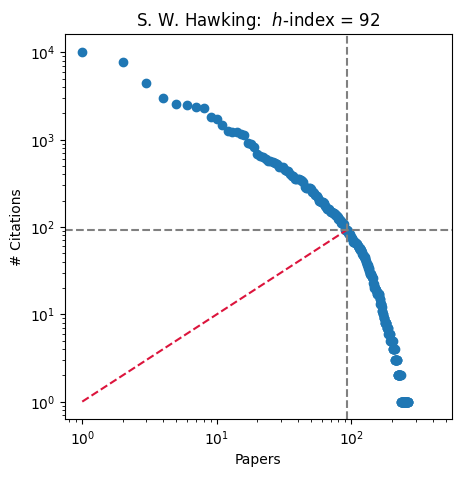

In [11]:
# 被引用数からh-indexを算出します
h_index = calculate_h_index(citations)

# グラフを作成します
fig, ax = plt.subplots(figsize=(5, 5))
title = f'{author_name}:  $h$-index = {h_index}'
plot_citations(ax, citations, h_index=h_index, title=title, logx=True, logy=True)
plt.show()

# 探索

## 3．重回帰分析によるh-index予測

2016年時点のデータに基づいて2024年のh-indexを予測します。
(若手研究者のみに絞るため、2016年のcareer_age<=7の研究者を選択します)
- X：
    - h_index_2016: 2016年時点のh-index
    - affiliation_h_index: institution.summary_stats.h_index
    - gender：男性、女性
    - race：USでの人種。白人、アフリカ系、アジア系、ヒスパニック系
- Y:
    - h_index: 'author.summary_stats.h_index'

In [12]:
# [from_year, to_year]の間に発表された論文が[from_year, to_year]の間に獲得した被引用数
def get_citations(works_json, from_year, to_year):
        n = 0
        citations = []
        for work in works_json:
            if (from_year <= work['publication_year'] <= to_year):
                n += 1
                cited_by_count_after = sum(entry['cited_by_count'] for entry in work['counts_by_year'] 
                              if entry['year'] > to_year)
                citations.append(work['cited_by_count'] - cited_by_count_after)
            else:
                continue
        return citations

### 学習データの準備

#### Get data samples

APIを利用しデータを獲得するには時間がかかるため、30人の小規模サンプルでデータ処理のプロセスを示します。その後、事前に処理されたデータを読み込んで分析を行います。

In [13]:
# './supplementary/career_age.pickle'から著者のサンプルを獲得します
career_age_df=pd.read_pickle('./supplementary/career_age.pickle')
career_age_df=career_age_df[(career_age_df['year']>=2009)&(career_age_df['year']<=2016)]\
    .reset_index(drop=True)
career_age_df=career_age_df.head(30)
print(f'Number of sampled authors: {career_age_df.shape[0]}')

Number of sampled authors: 30


In [14]:
# Get authors info by pyalex
authors_json = []
for index, entry in career_age_df.iterrows():
    if (index%10)==0:
        print(index)
    authors_json.append(Authors()[entry['id']])
authors_df = pd.DataFrame(authors_json)

0
10
20


In [15]:
# Get h_index
authors_df['h_index'] = authors_df['summary_stats'].apply(lambda x:x['h_index'])

# Clean up authors_df
authors_df = authors_df[['id','display_name','affiliations','counts_by_year','works_count','cited_by_count','h_index']]
# affiliation_h_indexが獲得できないデータを排除するため、affiliationsがあるデータを選択します。
authors_df = authors_df[authors_df['affiliations'].apply(len)>0]

# Get career_age
authors_df = pd.merge(authors_df, career_age_df, on='id', how='inner')
authors_df['career_age']=authors_df['year'].apply(lambda x:2024-x)

In [16]:
print(f'Number of authors with nonblank affiliations: {authors_df.shape[0]}')
authors_df.head()

Number of authors with nonblank affiliations: 10


,id,display_name,affiliations,counts_by_year,works_count,cited_by_count,h_index,year,career_age
0,https://openalex.org/A5074785474,Etienne Lefèvre,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2023, 'works_count': 0, 'cited_by_co...",1,11,1,2016,8
1,https://openalex.org/A5073704210,S. Khomiakov,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",10,145,6,2012,12
2,https://openalex.org/A5019666378,Michael Willochell,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",3,159,3,2010,14
3,https://openalex.org/A5001317537,Mamadou Diop,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2023, 'works_count': 0, 'cited_by_co...",9,20,3,2014,10
4,https://openalex.org/A5065962192,Paul Nye,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2021, 'works_count': 0, 'cited_by_co...",1,14,1,2016,8


#### Get gender and ethnicity from the Namsor API.

Namsorでは、名前からジェンダー、人種・民族などを推測することができます。
https://namsor.app/ からログインしてAPI keyを獲得できます。

In [17]:
import requests
import json

# API callを設定します。
# 推定したい名前をリストにして、APIの入力とします。
name_list=[]
for index, entry in authors_df.iterrows():
    name_list.append({"name": entry['display_name']})
payload = {"personalNames": name_list}
# "X-API-KEY"で自分のNamsor API keyを入れ替えます。
headers = {
    "X-API-KEY": "734e6b235405d5e1d7f112a76263bdf7", # YOUR_API_KEY
    "Accept": "application/json",
    "Content-Type": "application/json"
}

In [18]:
# Get gender and race data from 'display_name' by Namsor API
gender_url = "https://v2.namsor.com/NamSorAPIv2/api2/json/genderFullBatch"
gender_response = requests.request("POST", gender_url, json=payload, headers=headers)

race_url = "https://v2.namsor.com/NamSorAPIv2/api2/json/usRaceEthnicityFullBatch"
race_response = requests.request("POST", race_url, json=payload, headers=headers)

In [19]:
# Get name-gender dictionary from response
gender_json=json.loads(gender_response.text)
personal_names = gender_json['personalNames']
gender_dict = {}
for entry in personal_names:
    name = entry['name']
    gender = str(entry['likelyGender'])
    gender_dict[name] = gender

# Show first 10 rows in gender_dict
pprint({k: gender_dict[k] for k in list(gender_dict)[:10]})

{'Crystal Ng': 'female',
 'Etienne Lefèvre': 'male',
 'H.-D. Schwöbel': 'male',
 'Mamadou Diop': 'male',
 'Marat Kulakhmetov': 'male',
 'Meng Lu': 'male',
 'Michael Willochell': 'male',
 'Paul Nye': 'male',
 'S. Khomiakov': 'male',
 'Yehoshua Lehman': 'male'}


In [20]:
# Get name-race dictionary from response
race_json=json.loads(race_response.text)
personal_names = race_json['personalNames']
race_dict = {}
for entry in personal_names:
    name = entry['name']
    race = str(entry['raceEthnicity'])
    race_dict[name] = race

# Show first 10 rows in race_dict
pprint({k: race_dict[k] for k in list(race_dict)[:10]})

# Race ethnicities, based on the US Census Taxonomy:
# W_NL: white, non latino ;
# HL: hispano latino ;
# A: asian, non latino ;
# B_NL: black, non latino .

{'Crystal Ng': 'A',
 'Etienne Lefèvre': 'B_NL',
 'H.-D. Schwöbel': 'A',
 'Mamadou Diop': 'B_NL',
 'Marat Kulakhmetov': 'W_NL',
 'Meng Lu': 'A',
 'Michael Willochell': 'B_NL',
 'Paul Nye': 'W_NL',
 'S. Khomiakov': 'W_NL',
 'Yehoshua Lehman': 'W_NL'}


In [21]:
# Assign gender and ethnicity to authors
authors_df['gender'] = authors_df['display_name'].apply(lambda x: gender_dict[x])
authors_df['race'] = authors_df['display_name'].apply(lambda x: race_dict[x])

#### Get other variables

In [22]:
authors_df[['h_index_2016','affiliation_h_index']] = -1
authors_df[['cited_first_5yrs','works_first_5yrs','h_index_first_5yrs']] = -1
authors_df['cited_per_work_first_5yrs'] = -1.0
authors_df[['cited_first_10yrs','cited_6to10yrs']] = -1
predictor_year = 2016

for i, author in authors_df.iterrows():
    if (i)%10==0: print(i)

    pyalexObj = Works().filter(author={"id":author["id"]},is_paratext=False)\
                       .select(['cited_by_count','counts_by_year','publication_year'])\
                       .sort(publication_year="asc")
    works_json = util.getAll(pyalexObj, verbous=False)
    if works_json==[]:
        continue

    #-------------for Section 3--------------
    # Calculate h_index_2016
    citations = get_citations(works_json, author['year'], predictor_year)
    authors_df.loc[i,'h_index_2016']=calculate_h_index(citations)
    
    # Calculate affiliation_h_index
    affiliations = author["affiliations"]
    year = predictor_year
    found = False
    authors_df.loc[i,'affiliation_h_index'] = -1
    while (not found) and (year >= predictor_year-7):
        for af in affiliations:
            if year in af['years']:
                affiliation_h_index = Institutions()[af['institution']['id']]['summary_stats']['h_index']
                if authors_df.loc[i,'affiliation_h_index'] < affiliation_h_index:
                    authors_df.loc[i,'affiliation_h_index'] = affiliation_h_index
                found = True
        year -= 1
    
    #-------------for Section 4--------------
    # Calculate indices in the first 5 (and 10) years of the career
    if 2011 <= author['year'] <= 2014:
        citations_first_5yrs = get_citations(works_json, author['year'], author['year']+4)
        authors_df.loc[i,'works_first_5yrs']=len(citations_first_5yrs) 
        authors_df.loc[i,'cited_first_5yrs']=sum(citations_first_5yrs) 
        authors_df.loc[i,'cited_per_work_first_5yrs']=authors_df.loc[i,'cited_first_5yrs']/authors_df.loc[i,'works_first_5yrs']
        authors_df.loc[i,'h_index_first_5yrs']=calculate_h_index(citations_first_5yrs)
        # Calculate indices in the first 10 years of the career
        authors_df.loc[i,'cited_first_10yrs']=sum(get_citations(works_json, author['year'], author['year']+9)) 
        # Calculate indices in the 6th to 10th years of the career
        authors_df.loc[i,'cited_6to10yrs']=sum(get_citations(works_json, author['year']+5, author['year']+9)) 

0


In [23]:
authors_df

,id,display_name,affiliations,counts_by_year,works_count,cited_by_count,h_index,year,career_age,gender,race,h_index_2016,affiliation_h_index,cited_first_5yrs,works_first_5yrs,h_index_first_5yrs,cited_per_work_first_5yrs,cited_first_10yrs,cited_6to10yrs
0,https://openalex.org/A5074785474,Etienne Lefèvre,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2023, 'works_count': 0, 'cited_by_co...",1,11,1,2016,8,male,B_NL,0,327,-1,-1,-1,-1.00,-1,-1
1,https://openalex.org/A5073704210,S. Khomiakov,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",10,145,6,2012,12,male,W_NL,5,22,54,8,5,6.75,125,4
2,https://openalex.org/A5019666378,Michael Willochell,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",3,159,3,2010,14,male,B_NL,1,777,-1,-1,-1,-1.00,-1,-1
3,https://openalex.org/A5001317537,Mamadou Diop,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2023, 'works_count': 0, 'cited_by_co...",9,20,3,2014,10,male,B_NL,1,-1,5,5,1,1.00,20,10
4,https://openalex.org/A5065962192,Paul Nye,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2021, 'works_count': 0, 'cited_by_co...",1,14,1,2016,8,male,W_NL,1,616,-1,-1,-1,-1.00,-1,-1
5,https://openalex.org/A5075133075,Crystal Ng,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",5,41,3,2011,13,female,A,1,30,2,1,1,2.00,15,9
6,https://openalex.org/A5046936944,H.-D. Schwöbel,[{'institution': {'id': 'https://openalex.org/...,[],1,0,0,2009,15,male,A,0,64,-1,-1,-1,-1.00,-1,-1
7,https://openalex.org/A5085437310,Yehoshua Lehman,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2023, 'works_count': 0, 'cited_by_co...",2,6,1,2016,8,male,W_NL,0,-1,-1,-1,-1,-1.00,-1,-1
8,https://openalex.org/A5002564111,Meng Lu,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",9,22,1,2011,13,male,A,1,199,0,3,0,0.00,12,0
9,https://openalex.org/A5015392933,Marat Kulakhmetov,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",29,248,5,2010,14,male,W_NL,3,567,-1,-1,-1,-1.00,-1,-1


#### Get pre-processed data from supplementary

以上は小規模のサンプルでデータの獲得・処理のプロセスを示しました。これからは、career_age.pickleから獲得した、2016年時点のcareer_age<=7のすべての著者データを以上のようなプロセスで処理したものを使って分析を行います。

In [24]:
authors_df=pd.read_pickle('./supplementary/authors_h_index.pickle')

#### Plot the distributions

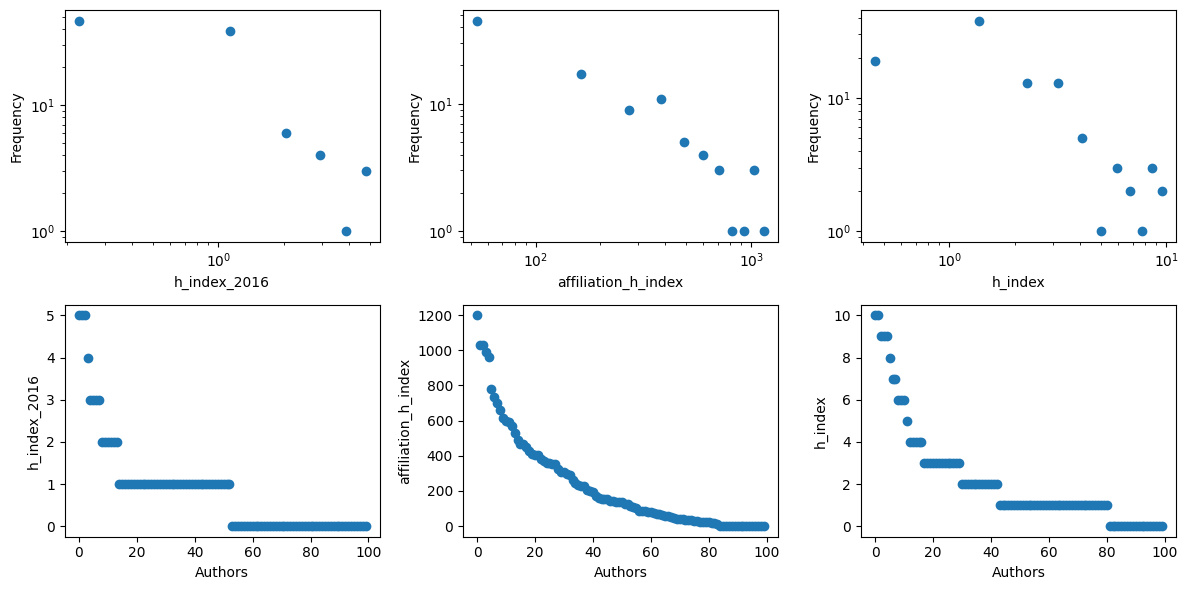

In [25]:
columns = ['h_index_2016','affiliation_h_index','h_index']
fig, axs = plt.subplots(2,3,figsize=(12,6))

# Plot distribution of frequency on 'h_index_2016','affiliation_h_index','h_index'
for i, col in enumerate(columns):
    ax = axs[0,i]
    num_bins = 10
    binned_frequencies, bin_edges = np.histogram(authors_df[col], bins=num_bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    ax.scatter(bin_centers, binned_frequencies, marker='o')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xscale('log')
    ax.set_yscale('log')

# Plot distribution of 'h_index_2016','affiliation_h_index','h_index' on authors
for i, col in enumerate(columns):
    ax = axs[1,i]
    ranking = authors_df[col].copy()
    ranking = sorted(ranking)[::-1]
    ax.scatter(np.arange(0, len(ranking)), ranking) 
    ax.set_xlabel('Authors')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

### 学習と予測

In [26]:
authors_valid=authors_df[authors_df['affiliation_h_index']>=0].reset_index(drop=True)
print(f'Number of valid data for regression: {authors_valid.shape[0]}')

Number of valid data for regression: 84


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score

# Define X and y of multiple regression analysis
X = authors_valid[['h_index_2016','affiliation_h_index','race','gender']].copy()
X['works_count']=authors_valid['works_count']
# X['career_age']=authors_valid['career_age']
# X['cited_by_count']=authors_valid['cited_by_count']
# X['sqrt_cited_by_count']=np.sqrt(authors_valid['cited_by_count'])
y = authors_valid['h_index'].copy()

# Convert race and gender to one hot vectors
column_trans = ColumnTransformer(
    [('race_category',OneHotEncoder(),['race']),
     ('gender_category',OneHotEncoder(),['gender'])],
    remainder='passthrough'
)
X = pd.get_dummies(X, columns=['gender','race'])#, drop_first=True)
X = X.apply(lambda x: x.map({True: 1, False: 0}) if x.dtype == bool else x)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Set up model
model = LinearRegression()

# Fitting
model.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = model.predict(X_train)

# Predictions on the test set
y_test_pred = model.predict(X_test)

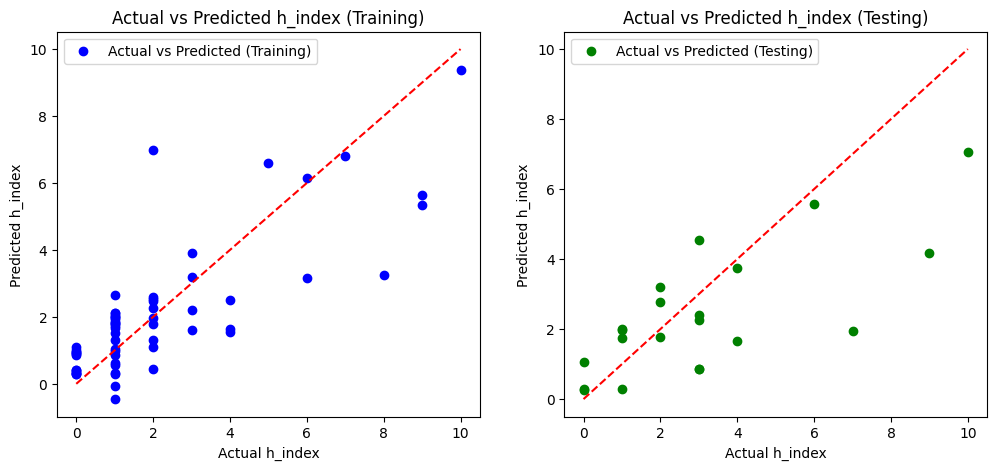

In [28]:
def plot_evaluation(ax, y, y_pred, *, type='', color='blue'):
    ax.scatter(y, y_pred, color=color, label=f'Actual vs Predicted ({type})')
    ax.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
    ax.set_xlabel('Actual h_index')
    ax.set_ylabel('Predicted h_index')
    ax.set_title(f'Actual vs Predicted h_index ({type})')
    ax.legend()
    
# 実測値と予測値の比較のグラフを作成する
fig, axs = plt.subplots(1,2,figsize=(12,5))
plot_evaluation(axs[0], y_train, y_train_pred, type='Training',color='blue')
plot_evaluation(axs[1], y_test, y_test_pred, type='Testing',color='green')
plt.show()

In [29]:
# Evaluate the model using R^2 score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training set R^2 score:", train_r2)
print("Testing set R^2 score:", test_r2)

Training set R^2 score: 0.6386240069961935
Testing set R^2 score: 0.4790920861254766


In [30]:
np.set_printoptions(suppress=True)
coefficients = {col: f'{coef:.3f}' for col, coef in zip(X.columns, model.coef_)}
pprint(coefficients)

{'affiliation_h_index': '0.001',
 'gender_female': '-0.282',
 'gender_male': '0.282',
 'h_index_2016': '0.885',
 'race_A': '0.388',
 'race_B_NL': '-1.102',
 'race_HL': '0.361',
 'race_W_NL': '0.353',
 'works_count': '0.100'}


## 4. h-indexで被引用数の長期的予測

Number of valid data for plotting: 39


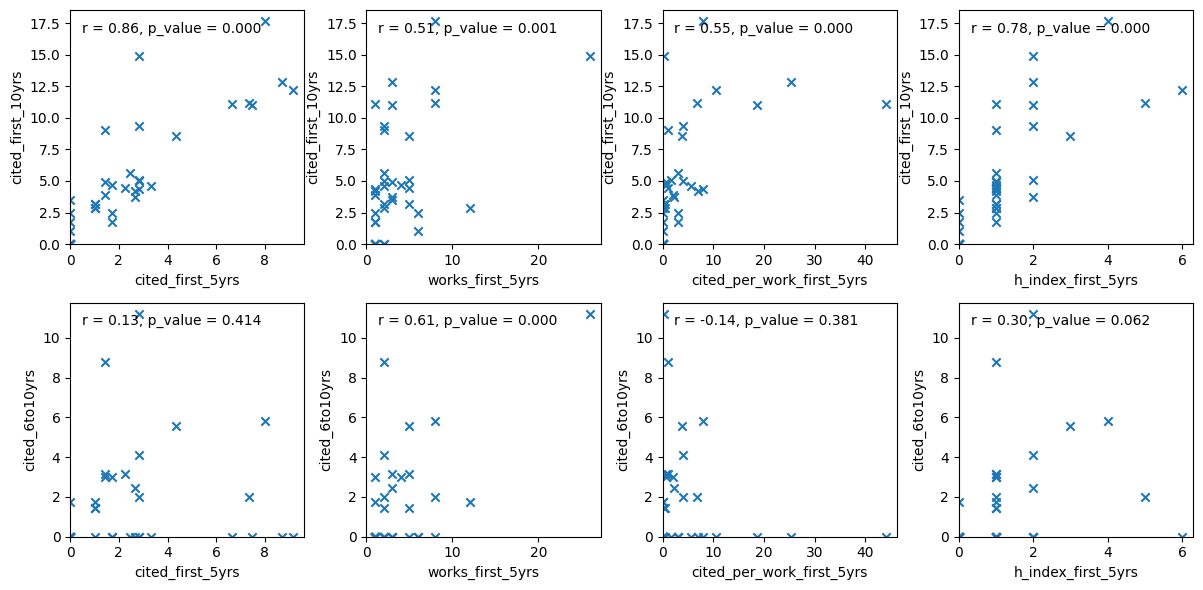

In [31]:
from scipy.stats import pearsonr

authors_valid_2=authors_df[(authors_df['h_index_first_5yrs']>=0)]
print(f'Number of valid data for plotting: {authors_valid_2.shape[0]}')

# Calculate the square root of the cited_by_count
XX = authors_valid_2[['cited_first_5yrs', 'works_first_5yrs', 'cited_per_work_first_5yrs', 'h_index_first_5yrs']].copy()
YY = authors_valid_2[['cited_first_10yrs', 'cited_6to10yrs']].copy()
XX[['cited_first_5yrs']] = XX[['cited_first_5yrs']].apply(np.sqrt)
YY = YY.apply(np.sqrt)

# Plot scattered graphs for all combinations of XX and YY
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for i, x_col in enumerate(XX.columns):
    for j, y_col in enumerate(YY.columns):
        ax = axs[j, i]
        ax.scatter(XX[x_col], YY[y_col], marker='x')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)

        # Compute correlation coefficient (r)
        r, p_value = pearsonr(XX[x_col], YY[y_col])
        ax.text(0.05, 0.95, f'r = {r:.2f}, p_value = {p_value:.3f}', transform=ax.transAxes, ha='left', va='top')

plt.tight_layout()
plt.show()

- (Row 1) キャリアの5年目の論文指標を利用し、10年目の総被引用数を予測するときには、sqrt(cited_first_5yrs)とh_index_first_5yrs（最初の5年の被引用数の平方根と第5年のh-index）は最も有用な指標である。
- (Row 2) さらに、キャリアの5年目の論文指標を利用し、5年目以降発表した論文の総被引用数を予測するときには、h_index_first_5yrsは最もいい予測指標である。

# Playground

## 5. 大学別h-index高い順に並べる

In [32]:
# 世界中の大学のh-indexランキング
ins_json = Institutions().select(['display_name','country_code','works_count','cited_by_count','summary_stats'])\
                         .sort(summary_stats={'h_index':'desc'}).get(per_page=10)
ins_df = pd.DataFrame(ins_json)

# Get h-index
ins_df['h_index'] = ins_df['summary_stats'].apply(lambda x:x['h_index'])
ins_df = ins_df.drop(columns=['summary_stats'])

display(ins_df)

,display_name,country_code,works_count,cited_by_count,h_index
0,Harvard University,US,587541,34233000,1533
1,Stanford University,US,404814,20539231,1299
2,Massachusetts Institute of Technology,US,270986,15461728,1198
3,Howard Hughes Medical Institute,US,82758,11935082,1180
4,"University of California, Berkeley",US,337646,16283225,1123
5,University of Washington,US,408778,16333769,1075
6,National Institutes of Health,US,235874,14733841,1066
7,Johns Hopkins University,US,374819,16328388,1061
8,University of Michigan–Ann Arbor,US,861048,16487312,1035
9,French National Centre for Scientific Research,FR,1038113,29837510,1032


In [33]:
# 日本の大学のh-indexランキング
ins_json = Institutions().select(['display_name','international','works_count','cited_by_count','summary_stats'])\
                         .filter(country_code='JP')\
                         .sort(summary_stats={'h_index':'desc'}).get(per_page=10)
ins_df = pd.DataFrame(ins_json)

# Get h-index
ins_df['h_index'] = ins_df['summary_stats'].apply(lambda x:x['h_index'])
ins_df = ins_df.drop(columns=['summary_stats'])

# Get Japanese name
jp_name = [entry['international']['display_name'].get('ja','-') for entry in ins_json]
ins_df['Japanese_name'] = jp_name
ins_df = ins_df.drop(columns=['international'])
ins_df.insert(ins_df.columns.get_loc('display_name') + 1, 'Japanese_name', ins_df.pop('Japanese_name'))

display(ins_df)

,display_name,Japanese_name,works_count,cited_by_count,h_index
0,The University of Tokyo,東京大学,402483,9996029,727
1,Kyoto University,京都大学,288894,7182048,646
2,Osaka University,大阪大学,246620,5589600,598
3,Japan Science and Technology Agency,-,52289,2651415,544
4,Tohoku University,東北大学,229793,4516434,493
5,Nagoya University,名古屋大学,170585,3378102,436
6,Kyushu University,九州大学,190124,3217406,420
7,National Institute of Advanced Industrial Scie...,産業技術総合研究所,80003,1890066,392
8,Tokyo Institute of Technology,東京工業大学,140341,2549463,391
9,Tokyo University of Science,東京理科大学,76864,1794774,389


## 6. 個人のh-indexを時系列でプロット

Section2と似ているようなプロセスで、ある研究者のh-indexを時系列でプロットします。  
OpenAlexのデータの制限により、時系列は2011年から2024までだけができます。

In [34]:
# 著者を検索します
name = "J. E. Hirsch"

auth_json = Authors().search_filter(display_name=name)\
            .select(["id","display_name","relevance_score","works_count","cited_by_count","summary_stats"]).get()
auth_df = pd.DataFrame(auth_json)
auth_df = auth_df.join(pd.DataFrame(auth_df['summary_stats'].tolist()))
auth_df = auth_df.drop(columns=['summary_stats'])

display(auth_df.head())

,id,display_name,relevance_score,works_count,cited_by_count,2yr_mean_citedness,h_index,i10_index
0,https://openalex.org/A5036688434,J. E. Hirsch,11917.848000,466,31822,1.875,69,249
1,https://openalex.org/A5072780714,J. E. Hirsch,655.623660,4,79,0.000,3,2
2,https://openalex.org/A5005488196,J. E. Hirsch,33.365334,1,0,0.000,0,0
3,https://openalex.org/A5031101292,J. E. Hirsch,33.351562,1,0,0.000,0,0
4,https://openalex.org/A5039441333,J. E. Hirsch,33.351562,1,0,0.000,0,0


In [35]:
# 検索結果から著者を指定します
i = 0
auth_id = auth_df.loc[i,"id"]
print(auth_id)
auth_name = auth_df.loc[i,"display_name"]

# 著者データを確認します
data = Authors()[auth_id]
# 著者の最新の所属機関
institutions = [entry['display_name'] for entry in data['last_known_institutions']]
print('\nLast known institutions of the select author:')
pprint(institutions)
# 著者が発表した論文のテーマ
concepts = [entry['display_name'] for entry in data['x_concepts']]
print('\nConcepts of the select author:')
pprint(concepts)

https://openalex.org/A5036688434

Last known institutions of the select author:
['University of California, San Diego']

Concepts of the select author:
['Physics',
 'Quantum mechanics',
 'Condensed matter physics',
 'Superconductivity',
 'Mathematics',
 'Materials science',
 'Nuclear physics',
 'Chemistry',
 'Engineering',
 'Electron',
 'Thermodynamics',
 'Organic chemistry',
 'Computer science',
 'Medicine',
 'Biology',
 'Statistics']


Fetching 467 objects. it may takes 0.04 to 0.12 minutes


4it [00:04,  1.07s/it]


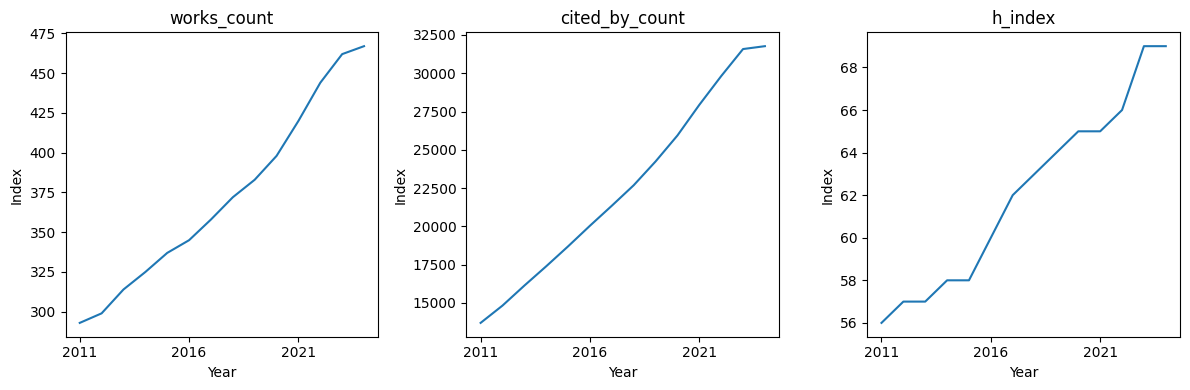

In [36]:
pyalexObj = Works().filter(author={"id":auth_id},is_paratext=False)\
                   .select(['cited_by_count','counts_by_year','publication_year'])\
                   .sort(publication_year="asc")
works_json = util.getAll(pyalexObj)

first_publication_year = works_json[0]["publication_year"] 
indices = pd.DataFrame(index=range(max(first_publication_year, 2011), 2025),
                         columns = ['works_count','cited_by_count','h_index'])

# Calculate h-index for each year
for year in range(max(first_publication_year, 2011), 2025):
    citations = get_citations(works_json, first_publication_year, year)
    indices.loc[year,'works_count']=len(citations)
    indices.loc[year,'cited_by_count']=sum(citations)
    indices.loc[year,'h_index']=calculate_h_index(citations)

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, col in enumerate(indices.columns):
        ax = axs[i]
        ax.plot(indices.index, indices[col])
        ax.set_xlabel('Year')
        ax.set_ylabel('Index')
        ax.set_title(col)
        ax.set_xticks(indices.index[::5])

plt.tight_layout()
plt.show()